In [157]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark')

In [130]:
df = pd.read_csv('../data/processed/games.csv', index_col=0)

In [131]:
df.head()

,steam_popularity,presence,storage,memory,original_cost,controller,achievements,g_action,g_adventure,g_casual,...,t_Sandbox,t_Sci-fi,t_Sexual Content,t_Shooter,t_Singleplayer,t_Story Rich,t_Survival,t_Turn-Based,t_Violent,t_Visual Novel
4,5,777456.0,50.0,4.0,39.99,1.0,308.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,158804.0,15.0,8.0,29.99,0.0,0.0,0,1,0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
12,13,634023.0,12.0,4.0,59.99,0.0,445.0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
21,22,92.0,80.0,8.0,59.99,1.0,101.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,25,291583.0,16.0,8.0,44.99,0.0,35.0,0,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [132]:
df.drop(['recommended', 'meh', 'exceptional', 'skip'], axis=1, inplace=True)

In [133]:
df.isna().sum()

steam_popularity    0
presence            0
storage             0
memory              0
original_cost       0
                   ..
t_Story Rich        0
t_Survival          0
t_Turn-Based        0
t_Violent           0
t_Visual Novel      0
Length: 83, dtype: int64

In [134]:
y = df['steam_popularity']
X = df.drop('steam_popularity', axis=1)

In [98]:
ss = StandardScaler()
X = ss.fit_transform(X)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=24)

In [136]:
lrg = LinearRegression()
lrg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [137]:
y_hat = lrg.predict(X_test)

In [138]:
r2 = r2_score(y_test, y_hat)

In [139]:
r2

0.425168184535371

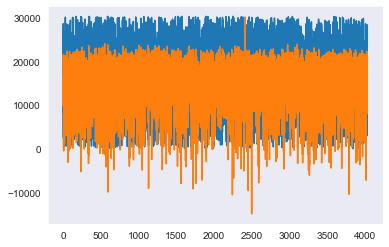

In [140]:
plt.plot(np.arange(0, len(y_test)), y_test)
plt.plot(y_hat)

In [174]:
model = XGBRegressor(objective='reg:squarederror', 
                     learning_rate= .03, 
                     max_depth=7, 
                     min_child_weight=4,
                     silent=1,
                     subsample=.7,
                     colsample_bytree=.7,
                     n_estimators=500
                     )
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=1, subsample=0.7, verbosity=1)

In [192]:
# Various hyper-parameters to tune
model = XGBRegressor()
parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [.03], #so called `eta` value
              'max_depth': [5],
              'min_child_weight': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(model,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.7min finished
0.513800182536696
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.7}


In [195]:
model = xgb_grid.best_estimator_

In [196]:
features_df = pd.DataFrame(model.feature_importances_, index=df.drop('steam_popularity', axis=1).columns)

In [197]:
features_df.sort_values(0, ascending=False)

,0
original_cost,0.058176
achievements,0.048883
t_Singleplayer,0.043811
t_Multiplayer,0.039134
t_Classic,0.036036
...,...
g_racing,0.004777
t_Shooter,0.004606
p_wii u,0.004348
p_ps vita,0.004139


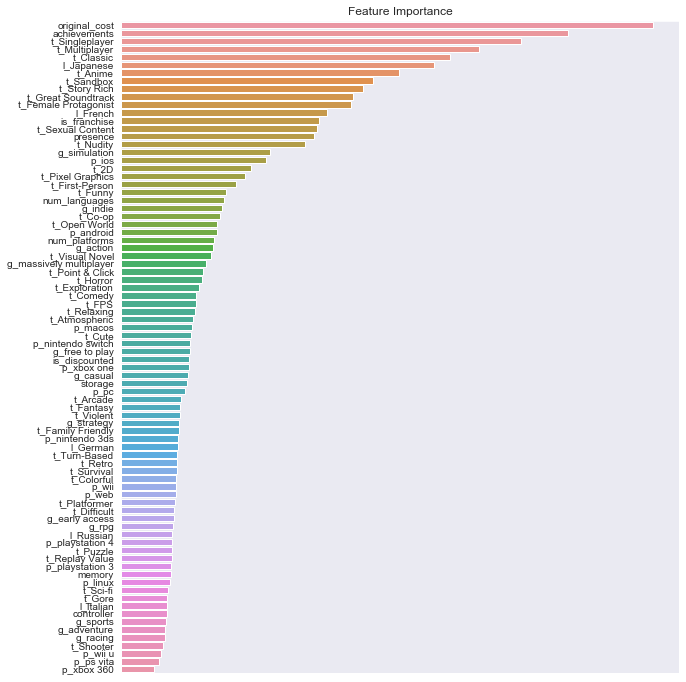

In [198]:
fig = plt.figure(figsize=(10, 12))
chart = sns.barplot(data=features_df.sort_values(0, ascending=False).T, orient='h')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_title('Feature Importance');

In [ ]:
game = {
    'achievements': 14
}
model.predict(game)